In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import zscore
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm

from lstm_ae import *

In [61]:
df = pd.read_csv('data/sepsis_df.csv')
df = df.iloc[:,1:] # omit the extra index column

state_cols = ['gender', 'age', 'elixhauser', 're_admission',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'cumulated_balance']

In [62]:
# z-score normalization (and de-normalization for later)

# these are either id or binary-valued columns
dont_touch_columns = ['icustayid', 'gender', 're_admission', 'mechvent', 'died_in_hosp', 'vaso_bin', 'iv_bin', 'terminal_state']

# this will store means and stds for each columns
col_gaussians = {}

def normalize(col):
    if col.name in dont_touch_columns:
        return col
    else:
        global col_gaussians
        col_gaussians[col.name] = (col.mean(), col.std())
        return zscore(col)


def denormalize(col):
    if col.name in dont_touch_columns:
        return col
    else:
        mean, std = col_gaussians[col.name]
        return (col * std) + mean


real_df = df.copy()
df = df.apply(normalize)

In [63]:
# state space representation using a recurrent (LSTM) autoencoder


class SepsisStateDataset(Dataset):
    """
    Torch dataset for sepsis state space data. Returns a tensor sequence of data 
    with size (seq_len, n_features). If the sequence is shorter than seq_len, it is
    padded with -1.
    """
    def __init__(self, df, state_cols, seq_len):
        self.sequences = []
        self.lengths = []
        
        for icustayid, group in df.groupby('icustayid'):
            seq = group[state_cols].values.astype(np.float32)
            length = len(seq)

            # pad with -1 if necessary
            if length < seq_len:
                pad = np.full((seq_len - length, len(state_cols)), -1)
                seq = np.concatenate([seq, pad], axis=0)

            seq = torch.tensor(seq, dtype=torch.float32)

            self.sequences.append(seq)
            self.lengths.append(length)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx]


def collate_fn(batch):
    sequences, lengths = zip(*batch)
    return torch.stack(sequences), torch.tensor(lengths)



SEQ_LEN = df['icustayid'].value_counts().max() # max # of datapoints for any patient in sepsis_df | 20
BATCH_SIZE = 64
LR = 0.001
N_EPOCHS = 500
N_FEATURES = len(state_cols) # 44
HIDDEN_DIM = 64
LATENT_DIM = 20

# split on ids to prevent splitting halfway through a trajectory
icustayids = df['icustayid'].unique()
cutoff1 = int(0.7 * len(icustayids))
cutoff2 = int(0.85 * len(icustayids))

train_ids = icustayids[:cutoff1]
train_df = df[df['icustayid'].isin(train_ids)]
train_dataset = SepsisStateDataset(train_df, state_cols, SEQ_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_ids = icustayids[cutoff1:cutoff2]
val_df = df[df['icustayid'].isin(val_ids)]
val_dataset = SepsisStateDataset(val_df, state_cols, SEQ_LEN)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_ids = icustayids[cutoff2:]
test_df = df[df['icustayid'].isin(test_ids)]
test_dataset = SepsisStateDataset(test_df, state_cols, SEQ_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAE(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def masked_mse_loss(output, target, pad_value=-1):
    mask = (target != pad_value)
    diff = (output - target)[mask]
    return torch.sum(diff**2) / torch.sum(mask)

In [27]:
# train and validate

train_losses = []
val_losses = []

for epoch in tqdm(range(N_EPOCHS)):
    model.train()
    total_loss = 0
    for batch, lengths in train_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        optimizer.zero_grad()
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss)

    # validate every 50 epochs
    if epoch % 50 == 0:
        model.eval()
        total_loss = 0
        for batch, lengths in val_dataloader:
            batch = batch.to(device) # (batch_size, sequence_length, num_features)
            output = model(batch, lengths) # (batch_size, sequence_length, num_features)
            loss = masked_mse_loss(output, batch)
            total_loss += loss.item()

        val_losses.append(total_loss)
        
    #print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


100%|█████████████████████████████████████████| 500/500 [18:58<00:00,  2.28s/it]


In [28]:
# test

test_losses = []
model.eval()
for epoch in tqdm(range(N_EPOCHS)):
    total_loss = 0
    for batch, lengths in test_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        
    test_losses.append(total_loss)
    #print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


100%|█████████████████████████████████████████| 500/500 [01:48<00:00,  4.59it/s]


In [64]:
plt.plot(train_losses, label='train')
plt.plot(np.linspace(0, 500, 10), val_losses, label='val')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss function for LSTM Autoencoder')
plt.legend()

print(f'mean train loss: {np.mean(train_losses)}')
print(f'mean val loss: {np.mean(val_losses)}')
print(f'mean test loss: {np.mean(test_losses)}')

NameError: name 'train_losses' is not defined

In [37]:
# careful, only run this if you want to overwrite the last model

#torch.save(model.encoder.state_dict(), 'models/lstm_encoder.pth')
#torch.save(model.decoder.state_dict(), 'models/lstm_decoder.pth')

In [65]:
# get the latent state representation for each timepoint, for each patient

dataset = SepsisStateDataset(df, state_cols, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

encoder = Encoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
encoder.load_state_dict(torch.load('models/lstm_encoder.pth', weights_only=True))
encoder.to(device)

decoder = Decoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
decoder.load_state_dict(torch.load('models/lstm_decoder.pth', weights_only=True))


latent_vectors = []
rec_states = []

for batch, lengths in dataloader:
    batch = batch.to(device) # batch: (batch_size, sequence_length, num_features)
    optimizer.zero_grad()

    # save latents
    latents, _ = encoder(batch, lengths, return_all_latents=True) # latents: (batch_size, sequence_length, latent_dim)
    for latent in latents: # latent: (total_num_of_timesteps_for_sequence_length_patients, latent_dim)
        latent_vectors.append(latent.detach().numpy()) # latent: (latent_dim,)

    # save reconstructed states
    x_enc, _ = encoder(batch, lengths)
    x_dec, _ = decoder(x_enc, lengths)
    for rec_state in x_dec:
        rec_states.append(rec_state.detach().numpy())
        

In [66]:
latent_vectors = np.array(latent_vectors)
print(latent_vectors.shape) # (total_num_of_timesteps, latent_dim) = (264589, 20)

latent_col_names = [f'latent_{num}' for num in range(1, 21)]
latent_df = pd.DataFrame(latent_vectors, columns=latent_col_names)
latent_df.insert(0, 'icustayid', df['icustayid'])
latent_df.insert(1, 'died_in_hosp', df['died_in_hosp'])
latent_df.insert(2, 'terminal_state', df['terminal_state'])
#latent_df.to_csv('data/latent_states.csv')
latent_df

(264589, 20)


,icustayid,died_in_hosp,terminal_state,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19,latent_20
0,3,0,0,0.216874,-0.009729,0.535055,0.397827,0.285779,0.212230,0.074800,...,-0.031026,-0.089653,0.290405,0.539273,0.050292,-0.054832,0.130655,-0.074702,0.016850,0.187498
1,3,0,0,0.506860,0.022461,0.443090,0.471947,0.171221,0.173830,0.082196,...,-0.050130,-0.074108,0.173827,0.402289,-0.016926,0.013587,0.010635,-0.072782,0.076020,0.168513
2,3,0,0,0.572232,0.052654,0.390099,0.474252,0.085953,0.173064,0.053743,...,-0.059697,-0.082432,0.141393,0.376831,-0.026813,0.097736,-0.028710,-0.085158,0.055686,0.211259
3,3,0,0,0.645734,0.019692,0.357612,0.478128,0.038009,0.174388,0.031941,...,-0.068373,-0.062549,0.125122,0.408303,-0.020989,0.131315,-0.061739,-0.088659,0.046290,0.207938
4,3,0,0,0.660966,0.010998,0.351446,0.491587,0.029472,0.179082,0.025599,...,-0.087081,-0.059799,0.109894,0.420509,-0.008457,0.125149,-0.066320,-0.103630,0.057117,0.189168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264584,99995,0,0,0.559981,0.576944,0.366330,0.511890,-0.413439,0.306440,0.900520,...,-0.055639,-0.163036,-0.153005,0.357764,0.315010,-0.019721,0.426375,-0.291304,0.769459,0.153897
264585,99995,0,0,0.566436,0.586461,0.374407,0.508254,-0.429414,0.318812,0.911403,...,-0.048655,-0.140937,-0.155958,0.364233,0.316449,-0.013356,0.434334,-0.301675,0.779861,0.153843
264586,99995,0,0,0.563254,0.573593,0.366684,0.492239,-0.431101,0.314823,0.900512,...,-0.048936,-0.131012,-0.160580,0.358079,0.327964,-0.000578,0.428106,-0.296396,0.786773,0.163643
264587,99995,0,0,0.564272,0.577578,0.362243,0.485562,-0.446830,0.321253,0.896188,...,-0.044879,-0.113988,-0.159186,0.363367,0.320348,0.007047,0.421235,-0.294402,0.783272,0.166391


In [68]:
rec_states = np.array(rec_states).reshape(-1, 44)
print(rec_states.shape) # (total_num_of_timesteps, n_features) = (264589, 44)

# TODO: check column names line up!!
rec_states_df = pd.DataFrame(rec_states, columns=state_cols)
rec_states_df = rec_states_df.apply(denormalize)
rec_states_df.insert(0, 'icustayid', df['icustayid'])
rec_states_df.insert(1, 'died_in_hosp', df['died_in_hosp'])
rec_states_df.insert(2, 'terminal_state', df['terminal_state'])
rec_states_df

#rec_states_df.to_csv('data/rec_states.csv')

(264589, 44)


,icustayid,died_in_hosp,terminal_state,gender,age,elixhauser,re_admission,Weight_kg,GCS,HR,...,Arterial_pH,paO2,paCO2,Arterial_BE,Arterial_lactate,HCO3,mechvent,Shock_Index,PaO2_FiO2,cumulated_balance
0,3,0,0,0.618080,29423.396484,4.180478,0.178647,76.809479,14.541247,83.538582,...,7.344255,204.105927,47.647411,0.522986,1.534001,24.880255,0.186256,0.593382,355.652985,1059.270142
1,3,0,0,0.645610,29102.925781,4.168446,0.152870,75.549736,14.252157,84.279869,...,7.342206,190.157791,49.198414,0.335969,1.463530,24.379314,0.311178,0.600854,295.184814,178.109802
2,3,0,0,0.685149,28785.416016,4.288010,0.156951,75.960083,14.310294,84.753265,...,7.348614,175.161957,48.636723,0.445909,1.490213,24.604723,0.358681,0.606484,287.383270,1328.122803
3,3,0,0,0.701063,28685.740234,4.212600,0.167680,76.710518,14.441557,85.331734,...,7.351058,166.550522,48.111038,0.382172,1.457020,24.588034,0.338328,0.605682,284.503845,1052.314331
4,3,0,0,0.720075,28567.873047,4.264593,0.172545,77.416817,14.450315,85.522980,...,7.352787,163.063538,47.850643,0.384777,1.410288,24.520599,0.307974,0.604059,284.446930,1178.052612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264584,99995,0,0,0.642808,20402.896484,3.947186,0.287484,50.556866,14.807882,65.801636,...,7.295348,182.659027,34.091293,2.028864,1.549540,35.175236,0.293815,0.567712,434.144745,-3751.983154
264585,99995,0,0,0.641151,20411.835938,3.946352,0.286865,50.568737,14.806468,65.767365,...,7.295498,182.571442,34.096336,2.028899,1.548464,35.178177,0.293213,0.566624,434.239563,-3779.599854
264586,99995,0,0,0.639548,20419.736328,3.945716,0.286432,50.581734,14.805387,65.734688,...,7.295616,182.511230,34.102123,2.027744,1.547433,35.182121,0.292723,0.565639,434.333069,-3802.003662
264587,99995,0,0,0.638006,20426.613281,3.945159,0.286122,50.595272,14.804485,65.704575,...,7.295707,182.468643,34.108078,2.025504,1.546534,35.186417,0.292341,0.564759,434.427551,-3821.204834


In [69]:
# visualize latent space with t-sne

latent_tsne = TSNE(n_components=2).fit_transform(latent_vectors)

In [70]:
latent_tsne_df = pd.DataFrame(data={
    'tsne_1': latent_tsne[:, 0],
    'tsne_2': latent_tsne[:, 1],
    'died_in_hosp': df['died_in_hosp'].values,
    'gender': df['gender'].values,
    'age_bin': (df['age'] > df['age'].mean()).astype(int),
    'SOFA': df['SOFA'].values,
    'vasos': df['vaso_bin'].values,
    'IVs': df['iv_bin'].values
})

latent_tsne_df

,tsne_1,tsne_2,died_in_hosp,gender,age_bin,SOFA,vasos,IVs
0,4.363358,-48.384472,0,0,0,-0.274012,0,2
1,-12.466600,-50.902550,0,0,0,-0.274012,0,2
2,-12.406256,-50.834126,0,0,0,-0.274012,0,2
3,-12.383023,-50.806366,0,0,0,-0.274012,0,2
4,-12.387152,-50.797417,0,0,0,-0.274012,0,2
...,...,...,...,...,...,...,...,...
264584,-39.319942,-59.204960,0,0,0,-1.714722,0,0
264585,-39.320507,-59.204926,0,0,0,-1.714722,0,0
264586,-39.320499,-59.206257,0,0,0,-1.714722,0,0
264587,-39.319359,-59.204865,0,0,0,-0.562154,0,0


In [ ]:
#plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='age_bin',
    palette='Set1',
    data=latent_tsne_df,
    alpha=0.7
)
plt.title('T-SNE Plot')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend(title='died_in_hosp')
plt.grid(True)
plt.tight_layout()
plt.show()

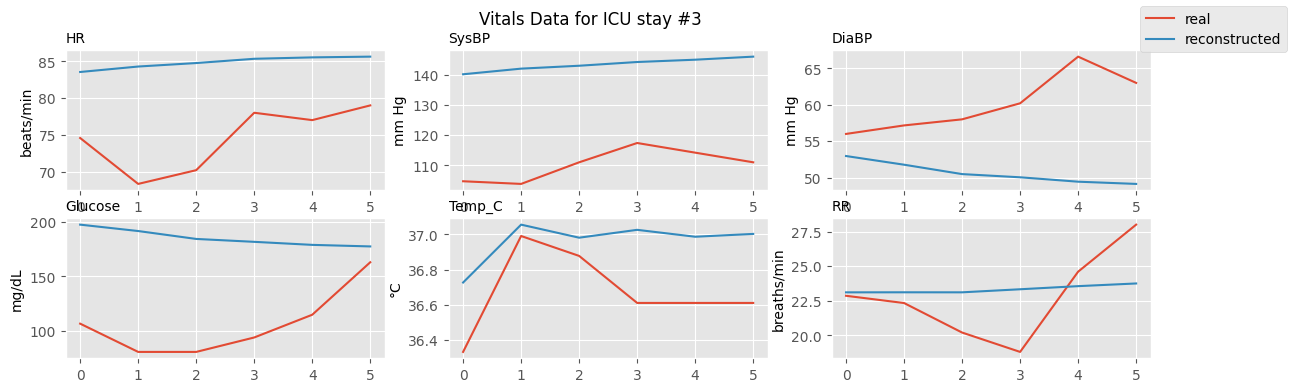

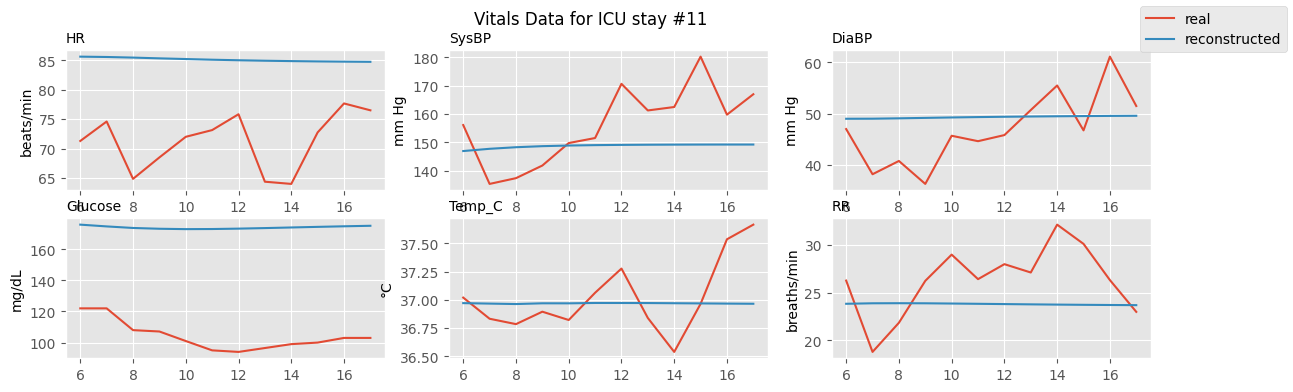

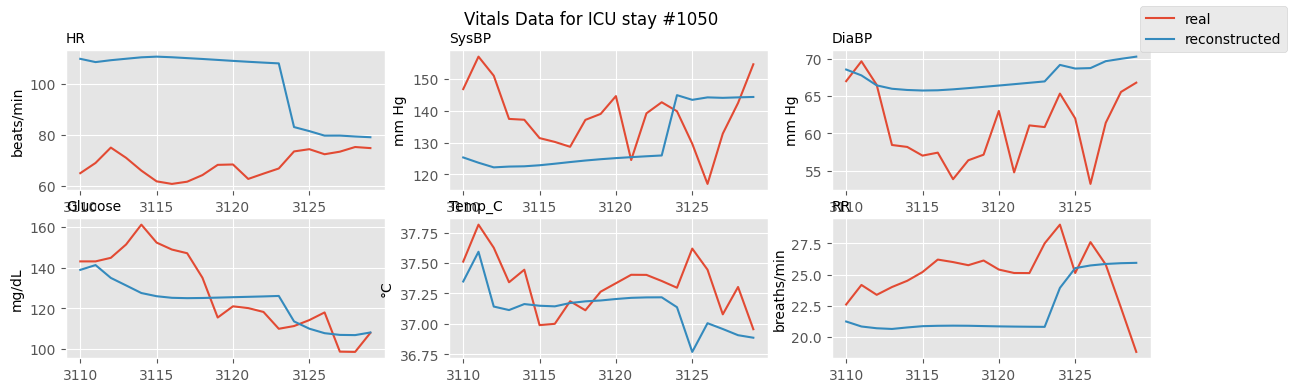

In [73]:
# visualize patient trajectories!

# plot patient trajectories

stats = ['HR', 'SysBP', 'DiaBP', 'Glucose', 'Temp_C', 'RR']
units = {'HR': 'beats/min', 'SysBP': 'mm Hg', 'DiaBP': 'mm Hg', 'Glucose': 'mg/dL', 'Temp_C': '°C', 'RR': 'breaths/min'}

def plot_trajectory(idx):
    
    patient_df = real_df[real_df['icustayid'] == idx]
    reconstructed_df = rec_states_df[rec_states_df['icustayid'] == idx]

    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, 3, figsize=(14,4))
    fig.suptitle(f'Vitals Data for ICU stay #{idx}')
    
    for ax, stat in zip(axs.flat, stats):
        ax.plot(patient_df[stat], label='real')
        ax.plot(reconstructed_df[stat], label='reconstructed')
        ax.set_title(stat, fontsize='medium', color='black', loc='left')
        ax.set_ylabel(units[stat], fontsize='medium', color='black')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()


plot_trajectory(3)
plot_trajectory(11)
plot_trajectory(1050)


In [57]:
for col in real_df.columns:
    mean, std = real_df[col].mean(), real_df[col].std()
    rec_mean, rec_std = rec_states_df[col].mean(), rec_states_df[col].std()
    print(f'original {col}: {mean=}, {std=}')
    print(f'reconstructed {col}: mean={rec_mean}, std={rec_std}')
    t_test, p_val = ttest_ind(real_df[col], rec_states_df[col])
    print(f'{t_test=}, {p_val}')
    print('\n')

original icustayid: mean=49757.04012260525, std=28857.754954655065
reconstructed icustayid: mean=49757.04012260525, std=28857.754954655065
t_test=0.0, 1.0


original gender: mean=0.43842336605074284, std=0.4961947689024849
reconstructed gender: mean=0.4243253767490387, std=0.19693271815776825
t_test=13.583976704220987, 5.066186652077798e-42


original age: mean=23608.2226751679, std=6072.702876779941
reconstructed age: mean=23506.744140625, std=5849.5615234375
t_test=6.1907072079452705, 5.993859544338225e-10


original elixhauser: mean=4.027128867791178, std=2.1737908111165245
reconstructed elixhauser: mean=4.041420936584473, std=2.1142594814300537
t_test=-2.4243441018223946, 0.015336399075931054


original re_admission: mean=0.32890256208685925, std=0.4698153903008983
reconstructed re_admission: mean=0.3158421516418457, std=0.18718896806240082
t_test=13.283763444274655, 2.91878869260182e-40


original died_in_hosp: mean=0.15926210084319453, std=0.36592101625797324
reconstructed died_i

KeyError: 'SOFA'